In [1]:
# Import Libraries
import math
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

File: 1001_DFA_ANG_XX.wav, Duration before trimming: 2.28s, Duration after trimming: 1.12s
Original and trimmed waveform for 1001_DFA_ANG_XX.wav


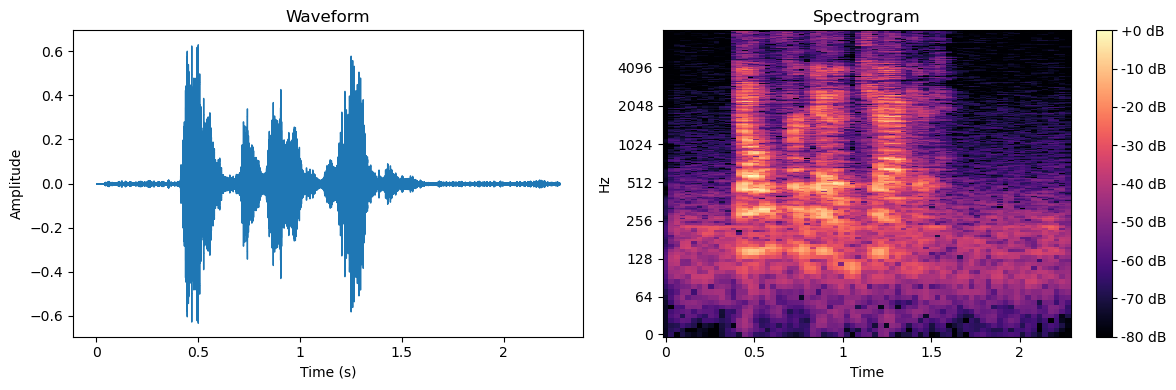

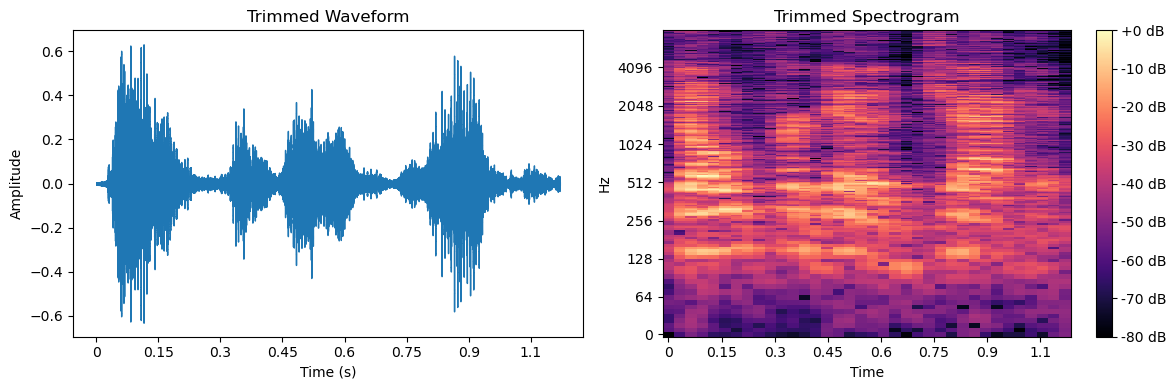

In [2]:
# Define audio file
audio_path = "AudioWav"

# Function to load and plot waveform and spectrogram
def plot_waveform_spectrogram(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Plot the waveform
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    # Plot the spectrogram
    plt.subplot(1, 2, 2)
    S = librosa.stft(y)
    S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")
    
    plt.tight_layout()
    plt.show()

# Silence removal function
def remove_silence(y, sr, top_db=20):
    # Trim silence from the beginning and end
    y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
    return y_trimmed

# Removing Silence and trimmed waveforms
for filename in os.listdir(audio_path):
    if filename.endswith(".wav"):  # Adjust for your audio file format
        file_path = os.path.join(audio_path, filename)
        
        # Load audio and remove silence
        y, sr = librosa.load(file_path, sr=None)
        y_trimmed = remove_silence(y, sr)
        
        # Print file info
        print(f"File: {filename}, Duration before trimming: {len(y)/sr:.2f}s, Duration after trimming: {len(y_trimmed)/sr:.2f}s")
        
        # Plot original and trimmed waveforms
        print(f"Original and trimmed waveform for {filename}")
        plot_waveform_spectrogram(file_path)
        
        # Plot the trimmed waveform and spectrogram
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y_trimmed, sr=sr)
        plt.title("Trimmed Waveform")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        
        plt.subplot(1, 2, 2)
        S_trimmed = librosa.stft(y_trimmed)
        S_dB_trimmed = librosa.amplitude_to_db(np.abs(S_trimmed), ref=np.max)
        librosa.display.specshow(S_dB_trimmed, sr=sr, x_axis="time", y_axis="log")
        plt.colorbar(format="%+2.0f dB")
        plt.title("Trimmed Spectrogram")
        
        plt.tight_layout()
        plt.show()

        # Stop after one file to ease of visualization
        break


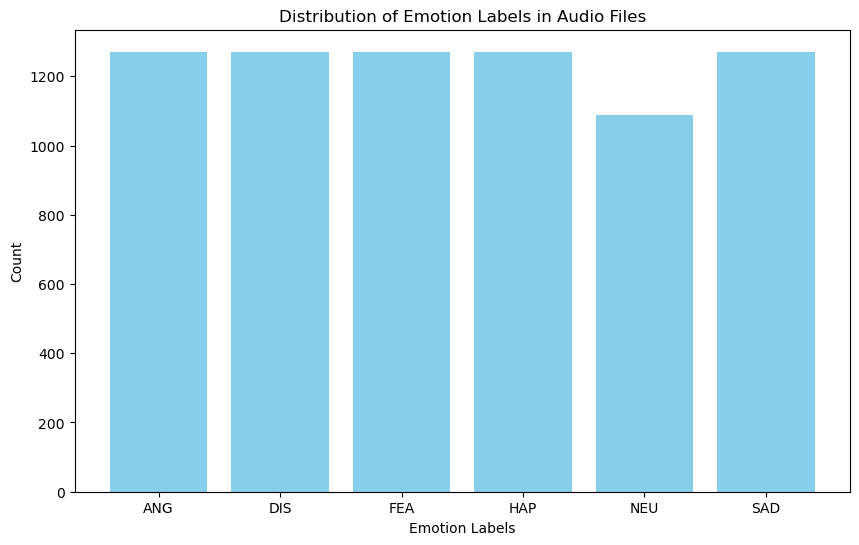

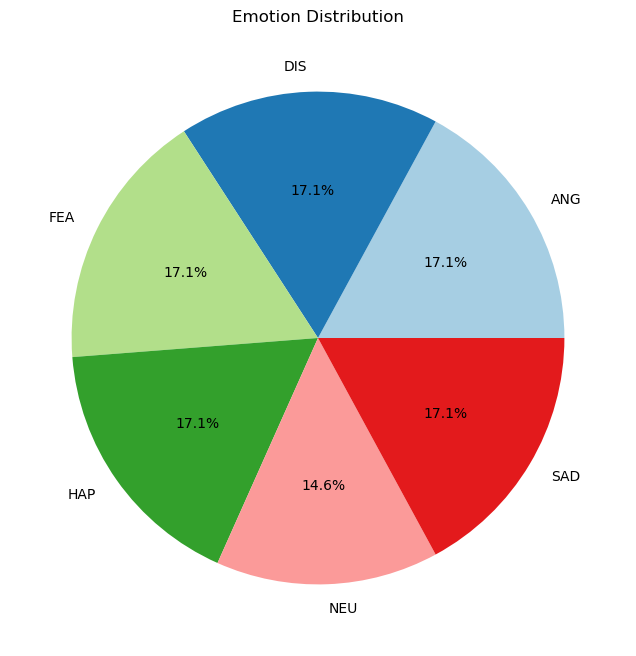

In [3]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Set the path to your AudioSubset folder
audio_speech = 'AudioWav'

# Extract labels from file names
labels = []
for file_name in os.listdir(audio_speech):
    if file_name.endswith('.wav'):
        label = file_name.split('_')[2]  # Assuming the label is the 3rd part of the file name
        labels.append(label)

# Count occurrences of each label
label_counts = Counter(labels)

# Plot the distribution as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.title('Distribution of Emotion Labels in Audio Files')
plt.show()

# Optional: Plot as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Emotion Distribution')
plt.show()


In [4]:
# Function to extract MFCCs with time dimension
def extract_audio_features(file_path, n_mfcc=40, max_len=200):
    # Load the audio file; sr=None preserves the native sampling rate
    audio, sample_rate = librosa.load(file_path, sr=None)

    # Remove silence from the audio
    audio_trimmed, _ = librosa.effects.trim(audio, top_db=30) # setting to 30 to not remove soft speech
    
    # Helper function for padding/truncating features
    def pad_or_truncate(feature, max_len):
        return (np.pad(feature, ((0, 0), (0, max_len - feature.shape[1])), mode='constant') 
                if feature.shape[1] < max_len else feature[:, :max_len])

    # Extract MFCC (Mel-frequency cepstral coefficients) features
    mfcc = librosa.feature.mfcc(y=audio_trimmed, sr=sample_rate, n_mfcc=n_mfcc)
    mfcc = pad_or_truncate(mfcc, max_len)
    
    return mfcc

# Directory containing audio files to process
audio_speech = 'AudioWAV'

# Lists to store extracted features and labels for each audio file
features = []
labels = []
# loop through each audio file and extract mfccs & labels
for file_name in os.listdir(audio_speech):
    if file_name.endswith('.wav'):  # Process only .wav files
        file_path = os.path.join(audio_speech, file_name)
        # Extract label based on filename (file name pattern ####_SentenceID_EmotionID_ToneID)
        # Emotion Labels are: Anger (ANG), Fear (FEA), Disgust (DIS), Happy (HAP), Neutral (NEU), Sad (SAD))
        label = file_name.split('_')[2]  # pulling the 3rd value from file name which is the emotion ID
        # Extract feature vector for the current file
        feature_vector = extract_audio_features(file_path)
        features.append(feature_vector)
        labels.append(label)

# Convert lists to DataFrame for easier data handling
feat_labs = pd.DataFrame({'Features': features, 'Label': labels})

# print features
print(feat_labs)

# Inspect unique labels extracted from file names
unique_labels = sorted(set(labels))
print("Unique Labels Extracted from File Names:", unique_labels)

                                               Features Label
0     [[-429.01093, -251.81676, -72.3528, -16.690092...   ANG
1     [[-494.1741, -463.85815, -459.60843, -453.1035...   DIS
2     [[-286.5918, -100.10147, -33.992016, -44.10035...   FEA
3     [[-414.47333, -190.91214, -70.63984, -35.19407...   HAP
4     [[-484.9637, -454.3514, -450.37292, -445.42505...   NEU
...                                                 ...   ...
7437  [[-541.3534, -512.39343, -513.9822, -510.95755...   DIS
7438  [[-500.56378, -506.89853, -517.6963, -514.3520...   FEA
7439  [[-546.4652, -513.5806, -509.9367, -507.84128,...   HAP
7440  [[-549.4096, -518.13605, -514.4069, -513.1063,...   NEU
7441  [[-555.97235, -515.94165, -507.71866, -508.487...   SAD

[7442 rows x 2 columns]
Unique Labels Extracted from File Names: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']


In [5]:
# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Verify the mapping between numeric and descriptive labels
label_mapping = {index: label for index, label in enumerate(le.classes_)}
print("Label Mapping (Numeric to Descriptive):", label_mapping)

# Convert features and labels intp numpy arrays
X = np.array(features)
y = np.array(labels)

# Split the data: 80% training, 10% validation, 10% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Flatten MFCC features for scaler fitting (samples x features)
X_train_flat = np.concatenate([mfcc.T for mfcc in X_train], axis=0)

# Fit scaler on the training set
scaler = StandardScaler()
scaler.fit(X_train_flat)

# Normalize features for each set
X_train_scaled = [scaler.transform(mfcc.T).T for mfcc in X_train]
X_val_scaled = [scaler.transform(mfcc.T).T for mfcc in X_val]
X_test_scaled = [scaler.transform(mfcc.T).T for mfcc in X_test]

# Convert to numpy arrays for further processing
X_train = np.array(X_train_scaled)
X_val = np.array(X_val_scaled)
X_test = np.array(X_test_scaled)

# Print shapes to verify
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=True)

# Print the split sizes for verification
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Label Mapping (Numeric to Descriptive): {0: 'ANG', 1: 'DIS', 2: 'FEA', 3: 'HAP', 4: 'NEU', 5: 'SAD'}
Train: (5953, 40, 200), Validation: (744, 40, 200), Test: (745, 40, 200)
Training set size: 5953
Validation set size: 744
Test set size: 745


In [6]:
# Define the CNN + LSTM model
class CNN_LSTM(nn.Module):
    def __init__(self, n_mfcc, max_len, num_classes):
        super(CNN_LSTM, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(0.5)
        
        # Calculate the output dimensions after CNN layers
        cnn_out_height = n_mfcc // 4  # Pooling reduces height by a factor of 2 twice
        cnn_out_width = max_len // 4  # Pooling reduces width by a factor of 2 twice
        lstm_input_size = 64 * cnn_out_height  # 64 channels * reduced height
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, num_layers=2, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        # CNN layers
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch, 1, n_mfcc, max_len)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Reshape for LSTM
        batch_size, _, height, width = x.size()
        x = x.view(batch_size, width, -1)  # (batch, sequence_length=width, features=channels*height)
        
        # LSTM layers
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output from the last time step
        
        # Fully connected layer
        x = self.fc(x)
        return x



In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model parameters
n_mfcc = 40
max_len = 200
num_classes = len(le.classes_)
model = CNN_LSTM(n_mfcc=n_mfcc, max_len=max_len, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Initialize lists to track losses
train_losses = []
val_losses = []
val_accuracies = []

# Training loop with validation
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # move to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Average training loss for epoch
    train_losses.append(running_loss / len(train_loader))
    
    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # move to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    # Avg validation loss and accuracy
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    # Print epoch stats
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # move to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
# Test model accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Using device: cuda
Epoch [1/15], Loss: 1.5121, Validation Loss: 1.4384, Validation Accuracy: 41.94%
Epoch [2/15], Loss: 1.3093, Validation Loss: 1.3888, Validation Accuracy: 46.64%
Epoch [3/15], Loss: 1.2151, Validation Loss: 1.2863, Validation Accuracy: 50.27%
Epoch [4/15], Loss: 1.0774, Validation Loss: 1.2687, Validation Accuracy: 50.00%
Epoch [5/15], Loss: 0.8869, Validation Loss: 1.3251, Validation Accuracy: 49.87%
Epoch [6/15], Loss: 0.6829, Validation Loss: 1.4272, Validation Accuracy: 49.19%
Epoch [7/15], Loss: 0.4764, Validation Loss: 1.7031, Validation Accuracy: 48.25%
Epoch [8/15], Loss: 0.3227, Validation Loss: 1.8997, Validation Accuracy: 48.79%
Epoch [9/15], Loss: 0.1899, Validation Loss: 2.0130, Validation Accuracy: 52.42%
Epoch [10/15], Loss: 0.1442, Validation Loss: 2.2696, Validation Accuracy: 48.12%
Epoch [11/15], Loss: 0.0952, Validation Loss: 2.5776, Validation Accuracy: 45.70%
Epoch [12/15], Loss: 0.0611, Validation Loss: 2.7595, Validation Accuracy: 47.58%
Epoch 

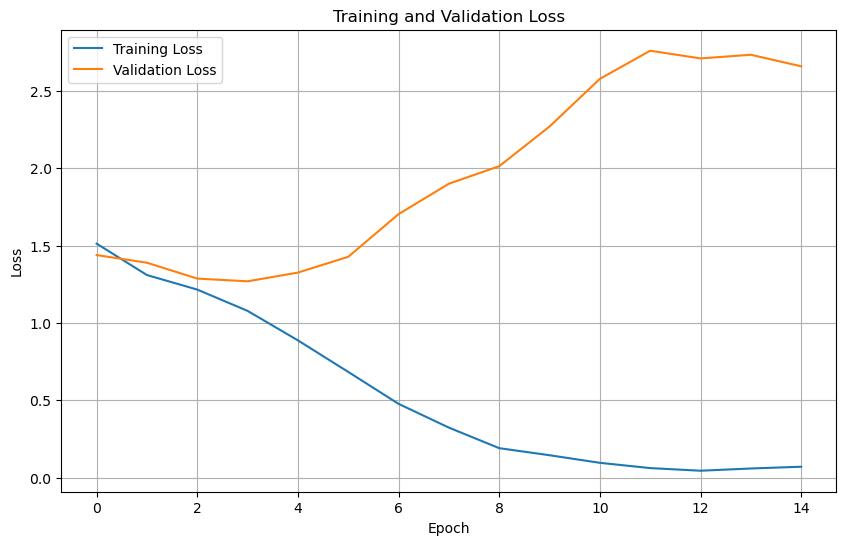

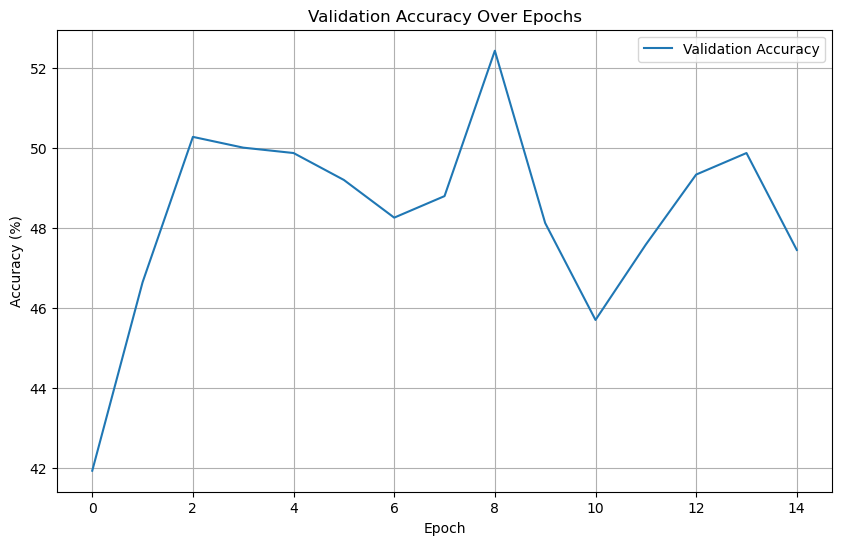

In [8]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Placeholder lists to store true and predicted labels
y_true = []
y_pred = []

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    # Use the test data loader to evaluate the model on the hold-out test set
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Extract the predicted class for each sample
        
        # Append true and predicted labels
        y_true.extend(y_batch.cpu().numpy())  # Convert true labels to numpy and add to list
        y_pred.extend(predicted.cpu().numpy())  # Convert predicted labels to numpy and add to list

# Convert lists to numpy arrays for evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Ensure that le.classes_ is a list of strings
print("le.classes_: ", le.classes_)
print("Type of le.classes_: ", type(le.classes_))
# Generate descriptive class names for classification report
class_names = [label_mapping[i] for i in range(len(label_mapping))]
print("Class Names for Evaluation:", class_names)


# Generate a classification report
report = classification_report(y_true, y_pred, target_names=class_names)  # Use the list of class names
print("Classification Report:")
print(report)

le.classes_:  ['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']
Type of le.classes_:  <class 'numpy.ndarray'>
Class Names for Evaluation: ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
Classification Report:
              precision    recall  f1-score   support

         ANG       0.63      0.70      0.66       127
         DIS       0.43      0.39      0.41       127
         FEA       0.37      0.30      0.33       127
         HAP       0.48      0.39      0.43       128
         NEU       0.51      0.56      0.53       109
         SAD       0.48      0.61      0.54       127

    accuracy                           0.49       745
   macro avg       0.48      0.49      0.48       745
weighted avg       0.48      0.49      0.48       745



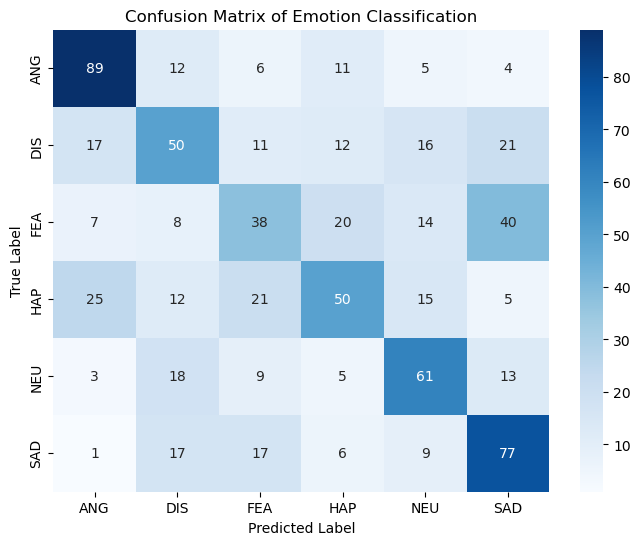

In [10]:
# Generate a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)  # Use string class names for labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Emotion Classification")
plt.show()

Using device: cuda
Extracted Features Shape: (22326, 798)
Encoded Labels Shape: (22326,)


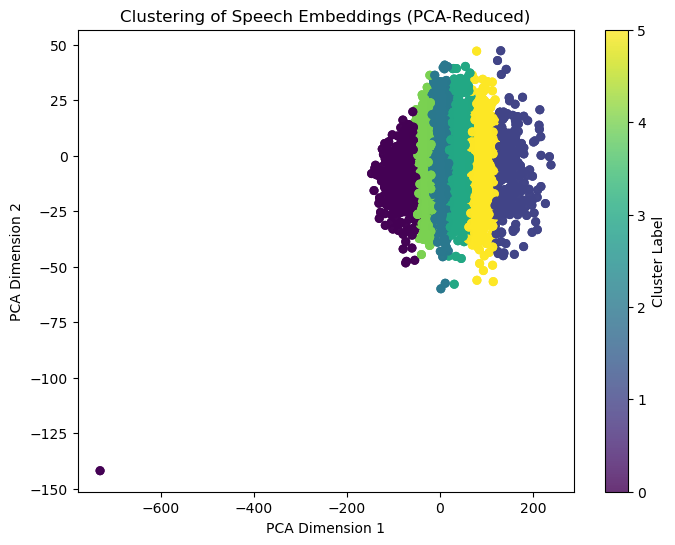

In [22]:
# from transformers import Wav2Vec2Model, Wav2Vec2Processor
from transformers import Wav2Vec2Processor, HubertModel, Wav2Vec2Model
from transformers import Wav2Vec2FeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load Pre-Trained HuBERT Model
model_name = "facebook/hubert-base-ls960"
hubert_model = HubertModel.from_pretrained(model_name)
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

# Device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# pre-trained model to device
hubert_model.to(device)

# extract features
def extract_hubert_features(file_path, processor, hubert_model, n_mfcc=30, min_duration=1.0):
    # load and preprocess audio
    audio, sample_rate = librosa.load(file_path, sr=16000)  # Resample to 16kHz

    # process audio with HuBERT
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = hubert_model(**inputs)
    # extract embeddings
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze(0).cpu().numpy()
    # transfer to CPU and convert to numpy
    #return embeddings.squeeze(0).cpu().numpy()
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio,sr=sample_rate, n_mfcc=n_mfcc)
    mfcc_mean = mfcc.mean(axis=1)

    # concat embeddings and MFCC features
    combined_features = np.concatenate((embeddings, mfcc_mean))

    return combined_features

# Audio File
audio_speech = 'AudioWAV'

# apply data augmentation
def augment_audio(audio):
    # Add random noise
    noise = np.random.normal(0, 0.01, audio.shape)
    audio_noise = audio + noise

    # Change pitch
    pitch_shifted = librosa.effects.pitch_shift(audio, sr=16000, n_steps=np.random.uniform(-2, 2))

    return [audio, audio_noise, pitch_shifted]

# Extract Features for Train, Validation, and Test Sets
features = []
labels = []

# Loop through each audio file in the directory
for file_name in os.listdir(audio_speech):
    if file_name.endswith('.wav'):  # Process only .wav files
        file_path = os.path.join(audio_speech, file_name)  # Construct the full file path
        label = file_name.split('_')[2]  # Extract the label from the filename (e.g., ANG)
        # Load audio
        audio, sample_rate = librosa.load(file_path, sr=16000)
        # Apply augmentations
        augmented_audios = augment_audio(audio)
        # Extract features for the current file
        for augmented_audio in augmented_audios:
            feature_vector = extract_hubert_features(file_path, processor, hubert_model)
            features.append(feature_vector)
            labels.append(label)

# Convert lists to NumPy arrays
X = np.array(features)
y = le.fit_transform(labels)  # Ensure labels are encoded for training

# Print extracted features and labels
print(f"Extracted Features Shape: {X.shape}")
print(f"Encoded Labels Shape: {y.shape}")

# Clustering on Extracted Features
num_clusters = len(le.classes_)  # Number of clusters = Number of emotion classes
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Visualize Clusters with PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_labels, cmap="viridis", s=30, alpha=0.8)
plt.colorbar(label="Cluster Label")
plt.title("Clustering of Speech Embeddings (PCA-Reduced)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

# Combine Clustering Results with Features (Optional)
X_augmented = np.hstack((X, cluster_labels.reshape(-1, 1)))  # Add cluster labels as a feature

# Add Scaler
scaler = StandardScaler()
# Split Dataset
X_train, X_temp, y_train, y_temp = train_test_split(X_augmented, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [23]:
# Train a Simple Classifier on Pre-Trained Features
class EmotionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_dim = X_train.shape[1]
num_classes = len(le.classes_)
pretrained_model = EmotionClassifier(input_dim=input_dim, num_classes=num_classes).to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Train and Validation Loop
num_epochs = 20 
for epoch in range(num_epochs):
    pretrained_model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Forward pass
        outputs = pretrained_model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation evaluation
    pretrained_model.eval()
    val_correct, val_total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = pretrained_model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()
    val_accuracy = 100 * val_correct / val_total

    # Print epoch stats
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Evaluate on Test Set
pretrained_model.eval()
test_correct = 0
test_total = 0
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = pretrained_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()
test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/20], Loss: 1.3903, Validation Loss: 1.0630, Validation Accuracy: 63.19%
Epoch [2/20], Loss: 1.0292, Validation Loss: 0.8442, Validation Accuracy: 69.64%
Epoch [3/20], Loss: 0.8791, Validation Loss: 0.7485, Validation Accuracy: 73.35%
Epoch [4/20], Loss: 0.7914, Validation Loss: 0.6838, Validation Accuracy: 74.43%
Epoch [5/20], Loss: 0.7377, Validation Loss: 0.6477, Validation Accuracy: 76.22%
Epoch [6/20], Loss: 0.6880, Validation Loss: 0.6032, Validation Accuracy: 77.79%
Epoch [7/20], Loss: 0.6469, Validation Loss: 0.5797, Validation Accuracy: 79.18%
Epoch [8/20], Loss: 0.6239, Validation Loss: 0.5647, Validation Accuracy: 79.00%
Epoch [9/20], Loss: 0.5967, Validation Loss: 0.5237, Validation Accuracy: 80.47%
Epoch [10/20], Loss: 0.5620, Validation Loss: 0.5115, Validation Accuracy: 81.73%
Epoch [11/20], Loss: 0.5437, Validation Loss: 0.4994, Validation Accuracy: 81.64%
Epoch [12/20], Loss: 0.5218, Validation Loss: 0.4688, Validation Accuracy: 82.49%
Epoch [13/20], Loss: 0.50

Test Accuracy: 87.82%
Classification Report for wav2vec2.0:
              precision    recall  f1-score   support

         ANG       0.96      0.93      0.94       382
         DIS       0.88      0.85      0.86       381
         FEA       0.83      0.83      0.83       381
         HAP       0.92      0.89      0.90       382
         NEU       0.89      0.97      0.93       326
         SAD       0.80      0.81      0.81       381

    accuracy                           0.88      2233
   macro avg       0.88      0.88      0.88      2233
weighted avg       0.88      0.88      0.88      2233



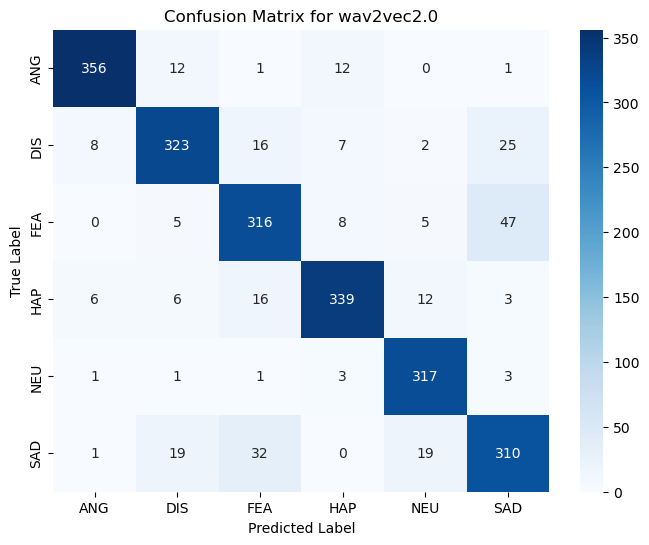

In [24]:
# Evaluate on Test Set
pretrained_model.eval()
test_correct = 0
test_total = 0
y_true, y_pred = [], []  # Initialize empty lists for true and predicted labels

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Move data to GPU if available
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = pretrained_model(X_batch)
        _, predicted = torch.max(outputs, 1)  # Get predicted class

        # Update counters for accuracy
        test_total += y_batch.size(0)
        test_correct += (predicted == y_batch).sum().item()

        # Collect true and predicted labels
        y_true.extend(y_batch.cpu().numpy())  # Convert to NumPy and append
        y_pred.extend(predicted.cpu().numpy())  # Convert to NumPy and append

# Calculate overall test accuracy
test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Convert y_true and y_pred to NumPy arrays for further evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
print("Classification Report for wav2vec2.0:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for wav2vec2.0")
plt.show()